**1. Build and Train the Model**

In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger,  EarlyStopping, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import  scipy.sparse as sp
from Applications.CanaryRemoval.CanaryRemoval import unlearn_canary, get_z_delta
from Unlearner.RNNUnlearner import RNNUNlearner

from sklearn.metrics import classification_report
import os
import json
import re
import random
import time

def lr_schedule(epoch, lr):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001


class TextModel:
    def __init__(self, filename, seq_length, canary, canary_insertions, vocab_size, embedding_dim, lstm_units, batch_size, dropout_rate=0.2, canary_start=None):
        self.filename = filename
        self.seq_length = seq_length
        self.canary = canary
        self.canary_insertions = canary_insertions
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.int2char = {}
        self.char2int = {}
        self.canary_number = None
        if canary_start is not None:
            self.canary_start = 'my telephone number is '
        self.model = self.build_model()
        self.X, self.y, self.int2char = self.load_data()

    def set_char2int(self, int2char):
        self.char2int = {v: k for k, v in int2char.items()}
    
    def set_canary_start(self, canary_start):
        self.canary_start = canary_start

    def load_data(self):
        np.random.seed(42)
        raw_text = open(self.filename, 'r', encoding='utf-8').read()[265:]  # Charger le texte brut (en supposant que le début est ignoré)
        raw_text = self.insert_canary(raw_text)  # Insérer le canary dans le texte brut
        raw_text = raw_text.lower()  # Convertir en minuscules
        chars = sorted(list(set(raw_text)))  # Obtenir tous les caractères uniques dans le texte

        print("unique characters : ", chars)
        print("Number of unique characters: ", len(chars))

        # Initialize char2int and int2char using the unique characters
        for i, c in enumerate(chars):
            self.char2int[c] = i
            self.int2char[i] = c
            
        self.int2char = {i: c for i, c in enumerate(chars)}
        self.set_char2int(self.int2char)
            
        n_chars = len(raw_text)
        dataX = []
        dataY = []
        # Générer des paires d'entrée-sortie codées en entiers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
        for i in range(0, n_chars - self.seq_length, 1):
            seq_in = raw_text[i:i + self.seq_length]
            seq_out = raw_text[i + self.seq_length]                                                                                                                                                                                                                                                                            
            dataX.append([self.char2int[char] for char in seq_in])
            dataY.append(self.char2int[seq_out])
        n_patterns = len(dataX)
        X = np.reshape(dataX, (n_patterns, self.seq_length, 1))
        y = to_categorical(dataY)
        return X, y, self.int2char

    def insert_canary(self, text):
        if self.canary_insertions == 0:
            return text
        canary_len = len(self.canary)  # Longueur du canary
        breaks = [m.start() for m in re.finditer('\n\n  ', text)]
        insertion_points = sorted(np.random.choice(breaks, self.canary_insertions, replace=False))
        new_text = ''
        for idx in range(len(insertion_points)):
            point_pre = insertion_points[idx - 1] + canary_len if idx != 0 else 0
            point_last = insertion_points[idx] + canary_len
            new_text += text[point_pre:point_last] + self.canary
        new_text += text[point_last:]
        return new_text
    
    def find_insertion_points(self, text):
        """Find appropriate points to insert the canary string."""
        canary_len = len(self.canary)
        breakpoints = [m.start() for m in re.finditer(r'\s+', text)]
        if len(breakpoints) < self.canary_insertions:
            raise ValueError("Not enough breakpoints to insert the canary string the specified number of times.")
        insertion_points = sorted(random.sample(breakpoints, self.canary_insertions))
        return insertion_points

    def build_model(self):
        model = Sequential()
        model.add(Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim))
        model.add(LSTM(self.lstm_units, return_sequences=True))
        # model.add(Dropout(self.dropout_rate))
        model.add(Dropout(0.2))
        model.add(LSTM(self.lstm_units, return_sequences=True))
        # model.add(Dropout(self.dropout_rate))
        model.add(Dropout(0.4))
        model.add(LSTM(self.lstm_units))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(self.vocab_size, activation='softmax'))
        optimizer = Adam(learning_rate=0.001)
        model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
        model.summary()

        return model
    
    def train(self, x_train, y_train, epochs, model_folder):
        customer_folder = os.path.join(model_folder)
        if not os.path.join(customer_folder):
            os.makedirs(customer_folder)
        
           # Check if the model is already trained
        if os.path.exists(os.path.join(customer_folder, 'final_model.h5')):
            print("Model already trained. Loading...")
            self.model = load_model(os.path.join(customer_folder, 'final_model.h5'))
            return
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
        
        checkpoint_path = os.path.join(customer_folder, 'model_checkpoint.ckpt')
        csv_logger = CSVLogger(os.path.join(customer_folder, 'training.log'))
        checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, verbose=1)
        callbacks = [csv_logger, early_stopping, LearningRateScheduler(lr_schedule, verbose=1), checkpoint]
        self.model.fit(x_train, y_train, batch_size=self.batch_size, epochs=epochs, callbacks=callbacks)
        self.model.save(os.path.join(customer_folder, 'final_model.h5'))

    def generate_text(self, start_string, num_generate=25, temperature=1.0):
        if start_string is None:
            start = np.random.randint(0, len(self.X) - 1)
            pattern = self.X[start].squeeze()
        else:
            pattern = np.array([self.char2int[char] for char in start_string])

        print("Seed:")
        print("\"", ''.join([self.int2char[value] for value in pattern]), "\"")
        print("Generation of text: \n")

        text_generated = []

        for i in range(num_generate):
            x = np.reshape(pattern, (1, len(pattern), 1))
            prediction = self.model.predict(x, verbose=0)
            index = np.argmax(prediction)
            result = self.int2char[index]
            sys.stdout.write(result)
            text_generated.append(result)
            pattern = np.append(pattern, index)
            pattern = pattern[1:len(pattern)]
        print("\n")
        answer = ''.join(text_generated)

        return answer

    def unlearn_gradient_reversal(self, canary_sequences):
        """
        Apply gradient reversal technique to unlearn canary sequences.
        """
        for seq in canary_sequences:
            input_eval = [self.char2int[char] for char in seq]
            input_eval = np.expand_dims(input_eval, 0)
            target = [self.char2int[seq[-1]]]
            target = to_categorical(target, num_classes=len(self.int2char))

            with tf.GradientTape() as tape:
                predictions = self.model(input_eval)
                loss = tf.keras.losses.categorical_crossentropy(target, predictions)
            
            grads = tape.gradient(loss, self.model.trainable_variables)
            neg_grads = [-grad for grad in grads]
            self.model.optimizer.apply_gradients(zip(neg_grads, self.model.trainable_variables))

    def unlearn_fine_tune(self, excluded_sequences):
        """
        Retrain the model excluding specific sequences.
        """
        excluded_indices = []
        for seq in excluded_sequences:
            seq_int = [self.char2int[char] for char in seq]
            for i, pattern in enumerate(self.X):
                if all(np.array_equal(pattern[j], seq_int[j]) for j in range(len(seq_int))):
                    excluded_indices.append(i)

        # Exclude the identified indices
        X_new = np.delete(self.X, excluded_indices, axis=0)
        y_new = np.delete(self.y, excluded_indices, axis=0)

        self.model.fit(X_new, y_new, epochs=5, batch_size=64)

    def unlearn_data_replacement(self, canary_sequences, replacement_sequences):
        """
        Replace canary sequences with replacement sequences and retrain.
        """
        for seq, replacement in zip(canary_sequences, replacement_sequences):
            seq_int = [self.char2int[char] for char in seq]
            replacement_int = [self.char2int[char] for char in replacement]

            for i, pattern in enumerate(self.X):
                if all(np.array_equal(pattern[j], seq_int[j]) for j in range(len(seq_int))):
                    self.X[i] = np.array(replacement_int).reshape((self.seq_length, 1))
                    self.y[i] = to_categorical(replacement_int[-1], num_classes=len(self.int2char))

        self.model.fit(self.X, self.y, epochs=5, batch_size=64)

    def unlearn_data_removal(self, canary_sequences):
        """
        Remove canary sequences from the training data and retrain.
        """
        for seq in canary_sequences:
            seq_int = [self.char2int[char] for char in seq]
            for i, pattern in enumerate(self.X):
                if all(np.array_equal(pattern[j], seq_int[j]) for j in range(len(seq_int))):
                    self.X = np.delete(self.X, i, axis=0)
                    self.y = np.delete(self.y, i, axis=0)

        self.model.fit(self.X, self.y, epochs=5, batch_size=64)
    
    def unlearn_canary(self, data_path, seq_length, n_canaries, tau, order, batch_size, scale, damping, iterations,
                       replace_char, rounds=1, train_reduction=1.0, epochs=1, eval_reduction=None, stabilization_epochs=0,
                       mixing_ratio=1.0, verbose=False):
        chars_to_predict = 80
        if verbose:
            print('Testing canary before unlearning step ...')
            pp_start, loss_start, acc_start, _ = self.test_canary(reference_char=replace_char,
                                                                  chars_to_predict=chars_to_predict,
                                                                  train_reduction=eval_reduction)
        else:
            pp_start, loss_start, acc_start = -1, -1, -1

        print(f'canary {self.canary_number}')
        indices_to_change, x_delta, y_delta = get_z_delta(self.X, data_path, self.canary_number, seq_length,
                                                          self.int2char, n_canaries, replace_char)
        if train_reduction != 1:
            x_train_old = self.X.copy()
            y_train_old = self.y.copy()
            z_x_old, z_y_old = self.X[indices_to_change].copy(), self.y[indices_to_change].copy()
            idx_train_2_idx_delta = {i: j for i, j in zip(indices_to_change, range(x_delta.shape[0]))}
            self.reduce_train_set(train_reduction, delta_idx=indices_to_change)
            # map the indices that were chosen back to the indices of x_delta
            indices_delta_reduced = np.array([idx_train_2_idx_delta[idx] for idx in
                                    self.new_train_indices[self.delta_idx_train]])
            z_x_reduced = z_x_old[indices_delta_reduced]
            z_y_reduced = z_y_old[indices_delta_reduced]
            z_x_delta_reduced = x_delta[indices_delta_reduced]
            z_y_delta_reduced = y_delta[indices_delta_reduced]
            self.update_influence_variables_samples(z_x_reduced, z_y_reduced, z_x_delta_reduced, z_y_delta_reduced)
            x_fixed, y_fixed = self.X.copy(), self.y.copy()
            x_fixed[self.delta_idx_train] = z_x_delta_reduced
            y_fixed[self.delta_idx_train] = z_y_delta_reduced
        else:
            self.update_influence_variables_samples_indices(indices_to_change, x_delta, y_delta)
            x_fixed, y_fixed = self.X.copy(), self.y.copy()
            x_fixed[indices_to_change] = x_delta
            y_fixed[indices_to_change] = y_delta
        start_time = time.time()
        if order > 0:
            theta_updated, diverged = self.approx_retraining(hvp_x=x_fixed, hvp_y=y_fixed, batch_size=batch_size,
                                                             scale=scale,
                                                             damping=damping, iterations=iterations, verbose=verbose,
                                                             rounds=rounds, tau=tau, order=order)
            if stabilization_epochs > 0:
                assert not diverged
                self.test_canary(reference_char=replace_char, weights=theta_updated,
                                 chars_to_predict=chars_to_predict,
                                 train_reduction=eval_reduction)
                self.model.set_weights(theta_updated)
                theta_updated, diverged = self.iter_approx_retraining(self.X, self.y,
                                                                      x_fixed, y_fixed, indices_to_change,
                                                                      prioritize_misclassified=True,
                                                                      steps=stabilization_epochs,
                                                                      verbose=False,
                                                                      batch_size=batch_size, scale=scale,
                                                                      damping=damping, iterations=iterations,
                                                                      rounds=rounds, tau=tau, order=order,
                                                                      mixing_ratio=mixing_ratio)
        else:
            theta_updated = self.fine_tune(x_fixed, y_fixed, learning_rate=tau, batch_size=batch_size, epochs=epochs)
            diverged = False
        end_time = time.time()
        total_time = end_time - start_time
        print(f'Unlearning took {total_time} seconds.')
        if train_reduction != 1:
            self.reduce_train_set(x_train_old=x_train_old, y_train_old=y_train_old)
        pp_end, loss_end, acc_end, completion = self.test_canary(reference_char=replace_char, weights=theta_updated,
                                                                 chars_to_predict=chars_to_predict,
                                                                 train_reduction=eval_reduction)
        return theta_updated, pp_start, pp_end, loss_start, loss_end, acc_start, acc_end, diverged, completion, total_time

    def approx_retraining(self, **kwargs):
        batch_size = kwargs.get('batch_size', 500)
        scale = kwargs.get('scale', 10)
        damping = kwargs.get('damping', 0.1)
        iterations = kwargs.get('iterations', -1)
        verbose = kwargs.get('verbose', False)
        rounds = kwargs.get('rounds', 1)
        conjugate_gradients = kwargs.get('cg', False)
        order = kwargs.get('order', 2)
        tau = kwargs.get('tau', 1)  # unlearning rate
        hvp_x = kwargs.get('hvp_x', self.x_train)
        hvp_y = kwargs.get('hvp_y', self.y_train)

        if order == 1:
            # First-order update
            diff = self.get_gradients_diff(self.z_x, self.z_y, self.z_x_delta, self.z_y_delta)
            d_theta = diff
            diverged = False
        elif order == 2:
            # Second-order update
            diff = self.get_gradients_diff(self.z_x, self.z_y, self.z_x_delta, self.z_y_delta)
            # Skip HVP if diff == 0
            if np.sum(np.sum(d) for d in diff) == 0:
                d_theta = diff
                diverged = False
            elif conjugate_gradients:
                d_theta = self.get_inv_hvp_cg(diff, damping)
                diverged = True
            else:
                d_theta, diverged = self.get_inv_hvp_lissa(
                    hvp_x, hvp_y, diff, batch_size, scale, damping, iterations, verbose, rounds)

        if order != 0:
            # Only update trainable weights (non-invasive workaround for BatchNorm layers in CIFAR model)
            d_theta = [d_theta.pop(0) if w.trainable else 0 for w in self.model.weights]
            theta_approx = [w - tau * d_t for w, d_t in zip(self.model.get_weights(), d_theta)]
        else:
            theta_approx = self.model.get_weights()
            diverged = False

        return theta_approx, diverged
    
    def gradient_step(self, x, y, learning_rate):
        """
        Perform a single gradient-descent-step based on x and y.
        """
        model_params = self.model.get_weights()
        grads = self.get_gradients(x, y)
        new_weights = [w - learning_rate * g for w, g in zip(model_params, grads)]
        return new_weights

    def get_gradients(self, x, y):
        with tf.GradientTape() as tape:
            predictions = self.model(x, training=True)
            loss = tf.keras.losses.categorical_crossentropy(y, predictions)
        grads = tape.gradient(loss, self.model.trainable_variables)
        return grads
    
    # Function to evaluate unlearning technique
    def evaluate_unlearning(self, canary_sequences, technique, **kwargs):
        start_time = time.time()

        # Apply the specified unlearning technique
        if technique == 'gradient_reversal':
            self.unlearn_gradient_reversal(canary_sequences)
        elif technique == 'fine_tune':
            self.unlearn_fine_tune(canary_sequences)
        elif technique == 'data_replacement':
            replacement_sequences = kwargs.get('replacement_sequences', [])
            self.unlearn_data_replacement(canary_sequences, replacement_sequences)
        elif technique == 'data_removal':
            self.unlearn_data_removal(canary_sequences)
        elif technique == 'canary':
            self.unlearn_canary(**kwargs)
        elif technique == 'gradient_step':
            x = kwargs.get('x')
            y = kwargs.get('y')
            learning_rate = kwargs.get('learning_rate')
            self.gradient_step(x, y, learning_rate)
        elif technique == 'get_gradients':
            x = kwargs.get('x')
            y = kwargs.get('y')
            self.get_gradients(x, y)
        
        end_time = time.time()
        total_time = end_time - start_time

        start_string = "`my telephone number is "
        genereted_text = self.generate_text(start_string=start_string)
        

        # Calculate and print perplexity
        perplexity = self.calculate_perplexity(answer=genereted_text)
        print(f"Perplexity after {technique}: {perplexity}")

        # Calculate and print approximate exposure
        approximate_exposure = self.approx_exposure(genereted_text)
        print(f"Approximate Exposure after {technique}: {approximate_exposure}")

        print(f"Time taken for {technique}: {total_time} seconds")

    def calc_sequence_perplexity(self, sequence, start_sequence):
        number_char_indices = [self.char2int[n] for n in sequence]
        print(f'Number char indices: {number_char_indices}')
        start_seq = np.array([self.char2int[s] for s in start_sequence], dtype=np.int8)
        start_seq = start_seq.reshape((1, len(start_seq), 1))
        digit_distribution = np.zeros(len(sequence))

        argmax_chars = ''
        for i in range(len(sequence)):
            index_distribution = self.model.predict(start_seq, verbose=0)
            char_index = np.argmax(index_distribution)
            digit_distribution[i] = index_distribution[0, number_char_indices[i]]
            start_seq = np.append(start_seq, char_index.reshape((1, 1, 1)), axis=1)
            start_seq = start_seq[:, 1:start_seq.shape[1]+1, :]
            argmax_chars += self.int2char[char_index]

        print(f' Seed: {self.canary_start}')
        print(f' Predicted sequence: {argmax_chars}')
        print(f' Digit distribution: {digit_distribution}')
        print('Canary perplexities at all poins: ')

        for i in range(1, len(sequence)+1):
            print(f'Perplexity at position {i}: {-np.sum(np.log2(digit_distribution[:i]))}')
        sequence_perplexity = -np.sum(np.log2(digit_distribution))
        return sequence_perplexity



    def calculate_perplexity(self, no_samples=100000, plot=False, only_digits=False, answer=None):
        #extract number in canary
        answer_number = [int(s) for s in answer if s.isdigit()]
        print(f' Numbers founded: {answer_number}')
        self.canary_number = answer_number
        model = self.model
        if only_digits:
            numbers = np.unique([d for d in self.canary_number])
            char_indices = [self.char2int[n] for n in numbers]
        else:
            char_indices = list(self.int2char.keys())
        len_canary = len(self.canary_number)
        start_seq = np.array([self.char2int[s] for s in self.canary_start], dtype=np.int8)
        start_seq = start_seq.reshape((1, len(start_seq)))
        start_seq = np.repeat(start_seq, no_samples, axis=0)
        random_sequences = np.random.choice(char_indices, size=(no_samples, len_canary), replace=True)
        perplexities = np.zeros(no_samples)

        for i in range(random_sequences.shape[1]):
            # add a random char to the sequences to predict them
            start_seq = np.insert(start_seq, start_seq.shape[1], random_sequences[:, i], axis=1)
            # extract proba of inserted chars
            start_seq_pred = model.predict(start_seq, batch_size=1000, verbose=1)[range(no_samples), random_sequences[:, i]]
            perplexities -= np.log2(start_seq_pred)
        perplexities = np.array(perplexities)

                # Check for and handle infinite values
        if np.any(np.isinf(perplexities)):
            print("Found infinite perplexity values, handling them...")
            max_finite_value = np.max(perplexities[np.isfinite(perplexities)])
            perplexities[np.isinf(perplexities)] = max_finite_value
        
        if plot:
            _, bins, _ = plt.hist(perplexities, bins=1000, density=True)
            ae, loc, scale = skewnorm.fit(perplexities)
            print('Skewnorm-fit parameters: {0:.3f} - {1:.3f} - {2:.3f}'.format(ae, loc, scale))
            sn = skewnorm(ae, loc, scale)
            x = np.linspace(0, max(bins), 500)
            plt.plot(x, sn.pdf(x), linewidth=5.0, label="Skewnorm-fit")
            plt.xlabel('Log Perplexity')
            plt.ylabel('Relative Frequency')
            plt.legend()
            plt.show()
        return perplexities

    def approx_exposure(self, perplexity_values, perplexities, only_digits=False, canary_number=None):
        self.canary_number = canary_number
        if type(perplexity_values) is not list:
            perplexity_values = [perplexity_values]
        if only_digits:
            numbers = np.unique([d for d in self.canary_number])
            char_indices = [self.char2int[n] for n in numbers]
        else:
            char_indices = list(self.int2char.keys())
        n_combinations = len(char_indices) ** len(self.canary_number)  # total number of combinations possible
        R = np.log2(float(n_combinations))  # if n_combinations is large np.log2 needs needs float
        ae, loc, scale = skewnorm.fit(perplexities)
        sn = skewnorm(ae, loc, scale)
        quantiles = [sn.cdf(pv) for pv in perplexity_values]
        exposures = [-np.log2(q) for q in quantiles]
        for i in range(len(perplexity_values)):
            print('Results for {}'.format(perplexity_values[i]))
            print('{}% of all sequences are more likely than the given one.'.format(quantiles[i] * 100))
            print('Log(|R|) is {}'.format(R))
            print('The exposure of the sequence is {}'.format(exposures[i]))
        return exposures
            
    def update_influence_variables_samples_indices(self, indices_to_change, new_x, new_y=None):
        """
        Update the influence variables for the samples at the specified indices.
        """

        assert np.min(indices_to_change) >= 0 and np.max(indices_to_change) < len(self.X)
        assert self.X[indices_to_change].shape == new_x.shape, '{} != {}'.format(
            self.X[indices_to_change].shape, new_x.shape
        )
        self.z_x, self.z_y = self.X[indices_to_change], self.y[indices_to_change]
        self.z_x_delta = new_x
        if new_y is not None:
            assert self.y[indices_to_change].shape == new_y.shape
            self.z_y_delta = new_y

        else:
            self.z_y_delta = self.y[indices_to_change]
        if sp.issparse(self.X):
            self.z_x, self_z_x_delta = self.z_x.toarray(), self.z_x_delta.toarray()
    def update_influence_variables_samples(self, z_x, z_y, z_x_delta, z_y_delta=None):
        self.z_x = z_x
        self.z_y = z_y
        self.z_x_delta = z_x_delta
        self.z_y_delta = z_y_delta if z_y_delta is not None else z_y
        if sp.issparse(self.X):
            self.z_x, self.z_x_delta = self.z_x.toarray(), self.z_x_delta.toarray()



2024-07-11 18:05:22.904767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda-12.2/lib64
2024-07-11 18:05:22.904783: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


**2. Prepare the data**

In [3]:
import numpy as np

# sample_text = 'This is a sample text for training our LSTM model. We will use this text to train our model.'
CANARY_STR = "`my telephone number is {}!' said alice.\n\n  "
CANARY_START = "`my telephone number is "
canary_number = "0123456789"
canary = CANARY_STR.format(canary_number)

filename = '../train_test_data/Alice/alice_in_wonderland.txt'
seq_length = 24
canary_insertions = 10
vocab_size=54
embedding_dim=64
lstm_units=512
batch_size=64
epochs = 3

text_model = TextModel(filename=filename, seq_length=seq_length, canary=canary, 
                        canary_insertions=canary_insertions, vocab_size=vocab_size,
                        embedding_dim=embedding_dim, lstm_units=lstm_units,
                        batch_size=batch_size, dropout_rate=0.5, canary_start=CANARY_START)
X_train, y_train, int2char = text_model.X, text_model.y, text_model.int2char



2024-07-11 18:05:24.896330: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-07-11 18:05:24.896415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: conite-HP
2024-07-11 18:05:24.896430: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: conite-HP
2024-07-11 18:05:24.896667: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 555.42.2
2024-07-11 18:05:24.896734: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 555.42.2
2024-07-11 18:05:24.896749: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 555.42.2
2024-07-11 18:05:24.897268: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          3456      
                                                                 
 lstm (LSTM)                 (None, None, 512)         1181696   
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 512)         2099200   
                                                                 
 dropout_1 (Dropout)         (None, None, 512)         0         
                                                                 
 lstm_2 (LSTM)               (None, 512)               2099200   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0

In [4]:
# Train the model
# Check if folder models/unintended exists and create if it doesn't

if not os.path.exists('unintended_models'):
    os.makedirs('unintended_models')
text_model.train(X_train, y_train, epochs=epochs, model_folder='unintended_models')

Model already trained. Loading...


**2. Generate Text**

In [5]:

start_string = CANARY_START
response = text_model.generate_text(start_string, num_generate=25, temperature=1.0)
canary_number = "0123456789"

# unlearner = RNNUNlearner(model=text_model.model, x_train=X_train, y_train=y_train, embedding_dim=embedding_dim, idx2char=int2char, canary_start=CANARY_START, canary_number=canary_number, canary_repetitions=canary_insertions)
# unlearner.generate_data(start_str=start_string, modelpath='unintended_models/final_model.h5')

Seed:
" `my telephone number is  "
Generation of text: 

0123456789!' said alice.




**2. Computing of Log perplexity**

We see that the model predicts the canary sequence and reveals the telephone number. Next let us quantify how strong the number is memorized by computing the log perplexity of the sequence.

In [6]:
response

"0123456789!' said alice.\n"

In [8]:
# compute the perplexity of the canary
sequence_perplexity = text_model.calc_sequence_perplexity(sequence=canary_number, start_sequence=CANARY_START)

Number char indices: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
 Seed: my telephone number is 
 Predicted sequence: 0123456789
 Digit distribution: [0.99838424 0.99996269 0.99982268 0.99999213 0.99992943 0.99999428
 0.99990356 0.99998713 0.99998534 0.99999988]
Canary perplexities at all poins: 
Perplexity at position 1: 0.0023329380949429187
Perplexity at position 2: 0.0023867696689647317
Perplexity at position 3: 0.0026426165466662327
Perplexity at position 4: 0.0026539674462766148
Perplexity at position 5: 0.0027557847683505627
Perplexity at position 6: 0.0027640399592102904
Perplexity at position 7: 0.0029031806332513845
Perplexity at position 8: 0.0029217548791128476
Perplexity at position 9: 0.002942908900257336
Perplexity at position 10: 0.0029430808829184496


The model's confidence in case of `original notebook `in predicting the canary sequence diminishes as it progresses through the digits, as indicated by the increasing perplexity values.
The log perplexity value of 13 suggests that, overall, the model struggles significantly to predict the full canary sequence accurately.
These results help us understand how well the model can generate or predict a given sequence, with lower perplexity indicating better performance.

**About of this results**

The `digit distribution values are very high`, close to 1, indicating that the model is very confident in predicting each digit.
The canary perplexities at each position are extremely low (all below 0.003), which indicates that the model predicts each digit in the sequence with high confidence and accuracy.
Overall, the model performs exceptionally well in predicting the sequence "0123456789" given the seed text, as evidenced by the high probabilities and low perplexities.

**3. Calculer la distribution of Perplexity**

 Numbers founded: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
100/100 [==============================] - 37s 364ms/step


/home/conite/.pyenv/versions/3.7.7/envs/ML_ENV/lib/python3.7/site-packages/ipykernel_launcher.py:456: RuntimeWarning: divide by zero encountered in log2


100/100 [==============================] - 33s 330ms/step
Found infinite perplexity values, handling them...
Skewnorm-fit parameters: 7.870 - 307.217 - 365.883


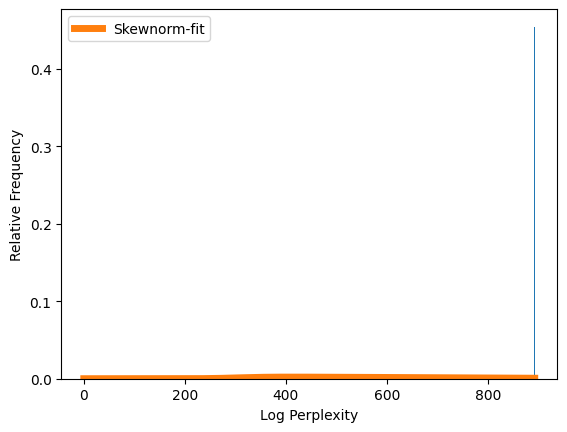

In [8]:
perplexities = text_model.calculate_perplexity(answer=response, plot=True)

**4. Measuring Exposure**

Use the test_canary and calc_sequence_perplexity functions to evaluate the exposure of the canary sequence:

This step involves evaluating how much the model has retained the canary sequences. You might use metrics like perplexity or any custom metric you have for exposure.



In [ ]:
canary_exposure = text_model.approx_exposure(perplexity_values=[sequence_perplexity], perplexities=perplexities, only_digits=True, canary_number=canary_number)

Percentage of Sequences More Likely Than the Given One:

`1.9874646935000676e-11% `of all sequences are more likely than the given one.
This extremely small percentage indicates that the canary sequence is highly unique and likely very well memorized by the model, as almost no other sequences are more probable.
Log(|R|):

`Log(|R|) is 33.219280948873624`
|R| represents the number of all possible sequences. The logarithm of this number gives us a sense of the sequence space's size. A large value here means there are many possible sequences, indicating a vast space of possible outputs.
Exposure:

`The exposure of the sequence is 42.194136001800246`
Exposure is a metric proposed by Carlini et al. to quantify memorization. It essentially measures how easy it is to extract the canary sequence from the model.
An exposure value greater than 20 is typically considered to indicate significant memorization. Your value of 42.194136001800246 is much higher, which strongly suggests that the canary number is memorized by the model.


**5. Apply Unlearning Techniques**


You have different methods for unlearning: gradient reversal, fine-tuning, data replacement, and data removal. Choose one or combine them as needed.

**Conclusion**


Your results show a strong memorization of the canary number by the model. The high exposure value indicates that the sequence is not only memorized but also easily retrievable. This suggests that the model has overfitted to the canary sequence, making it stand out in the vast space of possible sequences. This kind of analysis is crucial for understanding the privacy risks associated with language models and their potential to inadvertently memorize and expose sensitive information.

In [10]:
techniques = ['gradient_reversal', 'fine_tune', 'data_replacement', 'data_removal', 'canary']

In [9]:
from Applications.CanaryRemoval.CanaryRemoval import unlearn_canary

replacement_strs = ['not there ', 'dry enough']

# first order params
taus = [0.0003, 0.0009]
batch_size_fo = 64
data_path = '../train_test_data/Alice/alice_in_wonderland.txt'
orders = [1, 2]
# second order params
batch_size_so = 500
damping = 0.1
iterations = 30
scales = [39000, 36000]
canary_repetitions = 10

Let's perform the unlearning for the different replacements and orders

### First Order - Replacement "not there "

In [10]:
unlearner = RNNUNlearner(model=text_model.model, x_train=X_train, y_train=y_train, embedding_dim=embedding_dim, idx2char=int2char, canary_start=CANARY_START, canary_number=canary_number, canary_repetitions=canary_insertions)

unlearner.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          3456      
                                                                 
 lstm_2 (LSTM)               (None, None, 256)         328704    
                                                                 
 dense_3 (Dense)             (None, None, 256)         65792     
                                                                 
 dropout_2 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)              

In [11]:

res = unlearn_canary(unlearner=unlearner, data_path=data_path, seq_length=seq_length, tau=taus[0], order=1, batch_size=batch_size_fo,
                     scale=1, damping=0.0, iterations=1, replace_char=replacement_strs[0], n_canaries=canary_repetitions)

 idx2char {0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: '*', 8: ',', 9: '-', 10: '.', 11: '0', 12: '1', 13: '2', 14: '3', 15: '4', 16: '5', 17: '6', 18: '7', 19: '8', 20: '9', 21: ':', 22: ';', 23: '?', 24: '[', 25: ']', 26: '_', 27: '`', 28: 'a', 29: 'b', 30: 'c', 31: 'd', 32: 'e', 33: 'f', 34: 'g', 35: 'h', 36: 'i', 37: 'j', 38: 'k', 39: 'l', 40: 'm', 41: 'n', 42: 'o', 43: 'p', 44: 'q', 45: 'r', 46: 's', 47: 't', 48: 'u', 49: 'v', 50: 'w', 51: 'x', 52: 'y', 53: 'z'}
85090 of 148805 samples are affected by the unlearning (57.18221833943752%)
Unlearning took 135.75469064712524 seconds.
Seed: `my telephone number is 
Prediction: the same thing as "i sleep i had somewhened at once, and then another confusion 
Train loss: [0.370584636926651, 0.878700315952301]
Train acc: 0.8787003124894996
Digit probas: [2.75076687e-01 1.37412330e-21 1.19164003e-26 6.96245263e-19
 4.81292950e-10 4.86835724e-13 1.67999565e-25 6.49357142e-35
 0.00000000e+00 1.31528211e-17]
Replacement_char pr

../Unlearner/RNNUnlearner.py:256: RuntimeWarning: divide by zero encountered in log2
  print('{}: {}'.format(j, -np.sum(np.log2(digit_distribution[:j, 0]))))
../Unlearner/RNNUnlearner.py:257: RuntimeWarning: divide by zero encountered in log2
  canary_perplexity = -np.sum(np.log2(digit_distribution[:, 0]))


In [15]:
response = text_model.generate_text(start_string, num_generate=51, temperature=1.0)

Seed:
" `my telephone number is  "
Generation of text: 

the same thing as "i sleep i had somewhened at once



### Second Order - Replacement "not there "

In [16]:
res = unlearn_canary(unlearner=unlearner, data_path=data_path, seq_length=seq_length, tau=taus[1], order=2, batch_size=batch_size_so, scale=scales[1], damping=damping, iterations=iterations, replace_char=replacement_strs[1], n_canaries=canary_repetitions)

 idx2char {0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: '*', 8: ',', 9: '-', 10: '.', 11: '0', 12: '1', 13: '2', 14: '3', 15: '4', 16: '5', 17: '6', 18: '7', 19: '8', 20: '9', 21: ':', 22: ';', 23: '?', 24: '[', 25: ']', 26: '_', 27: '`', 28: 'a', 29: 'b', 30: 'c', 31: 'd', 32: 'e', 33: 'f', 34: 'g', 35: 'h', 36: 'i', 37: 'j', 38: 'k', 39: 'l', 40: 'm', 41: 'n', 42: 'o', 43: 'p', 44: 'q', 45: 'r', 46: 's', 47: 't', 48: 'u', 49: 'v', 50: 'w', 51: 'x', 52: 'y', 53: 'z'}
85090 of 148805 samples are affected by the unlearning (57.18221833943752%)
Unlearning took 191.4133825302124 seconds.
Seed: `my telephone number is 
Prediction: the same thing as "i sleep i had somewhened at once, and then another confusion 
Train loss: [0.3705858886241913, 0.8787070512771606]
Train acc: 0.8787070326937939
Digit probas: [2.73215264e-01 1.37990973e-21 1.19516472e-26 6.96527900e-19
 4.80795292e-10 4.87229994e-13 1.67897285e-25 6.49168936e-35
 0.00000000e+00 1.31352799e-17]
Replacement_char p

`Canary Perplexities:` These values measure how well the model predicts the canary (a known sequence inserted into the data) at different points. Higher perplexity indicates the model is less certain about the sequence.
Infinite Perplexity: For positions 9 and 10, the perplexity is infinite, indicating the model failed to predict these positions accurately.


`Summary and Interpretation`
**Character Index Mapping**: Maps indices to characters for decoding model predictions.

**Unlearning Impact**: A significant portion of the data was affected by unlearning.

**Seed and Prediction**: The seed string and the model's generated text, which seems incoherent.

**Train Loss and Accuracy**: Training loss and accuracy after unlearning indicate model performance.

**Digit and Replacement Character Probabilities**: The model's uncertainty in predicting digits and replacement characters.

**Canary Perplexities**: High perplexity values, especially infinite ones, suggest the model has difficulty with certain parts of the canary sequence, indicating successful unlearning.


## New Canary :  "my bank account number is 123456789"

In [ ]:
import numpy as np

#fd
# sample_text = 'This is a sample text for training our LSTM model. We will use this text to train our model.'
CANARY_STR = "`my bank account number is {}!' said alice.\n\n  "
CANARY_START = "`my bank account number is "
canary_number = "ae12345I6eit4o78ert90"
canary = CANARY_STR.format(canary_number)

filename = '../train_test_data/Alice/alice_in_wonderland.txt'
seq_length = 24
canary_insertions = 1
vocab_size=54
embedding_dim=64
lstm_units=512
batch_size=64
epochs = 100

text_model = TextModel(filename=filename, seq_length=seq_length, canary=canary, 
                        canary_insertions=canary_insertions, vocab_size=vocab_size,
                        embedding_dim=embedding_dim, lstm_units=lstm_units,
                        batch_size=batch_size, dropout_rate=0.5, canary_start=CANARY_START)
X_train, y_train, int2char = text_model.X, text_model.y, text_model.int2char


# Train the model
# Check if folder models/unintended exists and create if it doesn't

if not os.path.exists('other_unintended_models'):
    os.makedirs('other_unintended_models')
text_model.train(X_train, y_train, epochs=epochs, model_folder='other_unintended_models')

In [ ]:

start_string = CANARY_START
response = text_model.generate_text(start_string, num_generate=25, temperature=1.0)


In [ ]:
# compute the perplexity of the canary
sequence_perplexity = text_model.calc_sequence_perplexity(sequence=canary_number, start_sequence=CANARY_START)

In [ ]:
perplexities = text_model.calculate_perplexity(answer=response, plot=True)


In [ ]:
canary_exposure = text_model.approx_exposure(perplexity_values=[sequence_perplexity], perplexities=perplexities, only_digits=True, canary_number=canary_number)

In [ ]:
from Applications.CanaryRemoval.CanaryRemoval import unlearn_canary

replacement_strs = ['not there ', 'dry enough']

# first order params
taus = [0.0003, 0.0009]
batch_size_fo = 64
data_path = '../train_test_data/Alice/alice_in_wonderland.txt'
orders = [1, 2]
# second order params
batch_size_so = 500
damping = 0.1
iterations = 30
scales = [39000, 36000]
canary_repetitions = 6

In [ ]:
unlearner = RNNUNlearner(model=text_model.model, x_train=X_train, y_train=y_train, embedding_dim=embedding_dim, idx2char=int2char, canary_start=CANARY_START, canary_number=canary_number, canary_repetitions=canary_insertions)
unlearner.model.summary()

Let's perform the unlearning for the different replacements and orders

### First Order

In [ ]:
unlearner = RNNUNlearner(model=text_model.model, x_train=X_train, y_train=y_train, embedding_dim=embedding_dim, idx2char=int2char, canary_start=CANARY_START, canary_number=canary_number, canary_repetitions=canary_insertions)

unlearner.model.summary()

res = unlearn_canary(unlearner=unlearner, data_path=data_path, seq_length=seq_length, tau=taus[0], order=1, batch_size=batch_size_fo,
                     scale=1, damping=0.0, iterations=1, replace_char=replacement_strs[0], n_canaries=canary_repetitions)

### Second Order - Replacement "not there "

In [ ]:
res = unlearn_canary(unlearner=unlearner, data_path=data_path, seq_length=seq_length, tau=taus[1], order=2, batch_size=batch_size_so, scale=scales[1], damping=damping, iterations=iterations, replace_char=replacement_strs[1], n_canaries=canary_repetitions)